In [1]:
from sklearn.model_selection import train_test_split
from sklearn import datasets, svm
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
import numpy as np
from math import sqrt
from shapleycomposition import ShapleyExplainer
from composition_stats import ilr, sbp_basis
from bifurc_tree import create_tree_from_sbp, init_graph, build_graph
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import os

In [2]:
example = '3classes'
out_dir = os.path.join('figures', example, 'gaussians')
os.makedirs(out_dir, exist_ok=True)

## Selecting a qualitative colormap colourblind friendly

Check more details in https://matplotlib.org/stable/users/explain/colors/colormaps.html#colorblindness

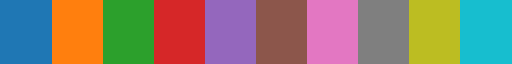

In [3]:
cm = plt.cm.tab10
colors = cm.colors
cm

# Definition of the dataset

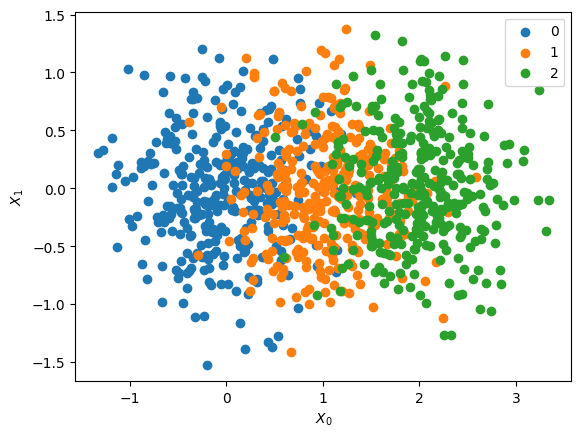

In [4]:
from sklearn.datasets import make_blobs

random_state = 0
n_samples = 1000
n_features = 2

centers = [[0, 0], [1, 0], [2, 0]]
cluster_std = [.5]*3

n_classes = len(centers)

X, Y = make_blobs(n_samples=n_samples, n_features=n_features,
                          centers=centers, cluster_std=cluster_std,
                          shuffle=True,
                          random_state=random_state)

# Split dataset
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

for y in range(n_classes):
    class_indices = Y == y
    plt.scatter(X[class_indices,0], X[class_indices,1], color=colors[y], label=y)
plt.xlabel('$X_0$')
plt.ylabel('$X_1$')
plt.legend()

## Selection of points of interest

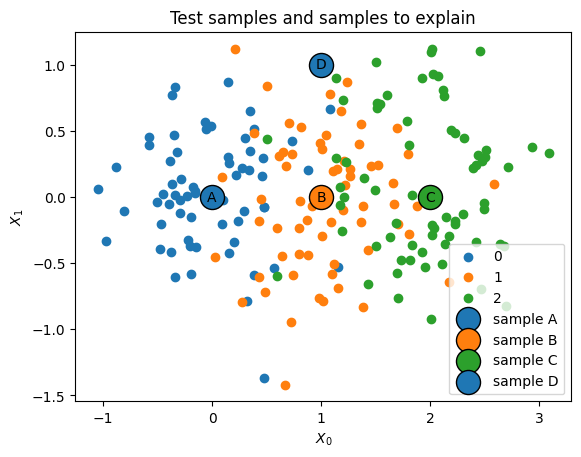

In [67]:
samples_of_interest = {'A': {'X': np.array([0, 0]), 'Y': 0},
                       'B': {'X': np.array([1, 0]), 'Y': 1},
                       'C': {'X': np.array([2, 0]), 'Y': 2},
                       'D': {'X': np.array([1, 1]), 'Y': 0}}

for y in range(n_classes):
    class_indices = Y_test == y
    plt.scatter(X_test[class_indices,0], X_test[class_indices,1], label=y)

for sample_id, sample in samples_of_interest.items():
    plt.scatter(sample['X'][0], sample['X'][1], color=colors[sample['Y']],
                s=300, marker='o', edgecolors='k',label=f"sample {sample_id}")
    plt.text(sample['X'][0], sample['X'][1], sample_id, 
             horizontalalignment='center', verticalalignment='center')
    
plt.xlabel('$X_0$')
plt.ylabel('$X_1$')
plt.title('Test samples and samples to explain')

plt.legend()

# Training a model

In [68]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
#clf = svm.SVC(kernel='linear', probability=True)
clf.fit(X_train, Y_train)

LogisticRegression()

## Decision boundaries

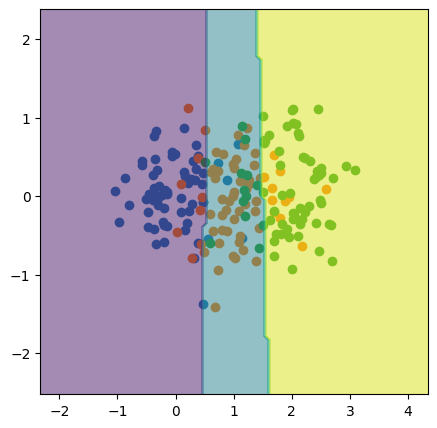

In [69]:
from sklearn.inspection import DecisionBoundaryDisplay

fig = plt.figure(figsize=(5, 5))
for y in range(n_classes):
    class_indices = Y_test == y
    plt.scatter(X_test[class_indices,0], X_test[class_indices,1], label=y)
DecisionBoundaryDisplay.from_estimator(clf, X, alpha=0.5, response_method='predict', ax=plt.gca())

## Predicted posterior probabilities per class

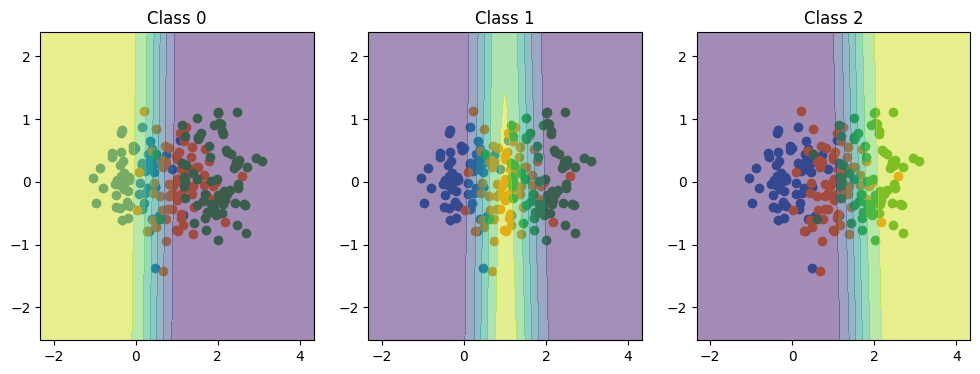

In [70]:
fig = plt.figure(figsize=(12, 4))
for i in range(n_classes):
    ax = plt.subplot(1, n_classes, i+1)
    ax.set_title(f"Class {i}")
    for y in range(n_classes):
        class_indices = Y_test == y
        plt.scatter(X_test[class_indices,0], X_test[class_indices,1], label=y)
    DecisionBoundaryDisplay.from_estimator(clf, X, alpha=0.5, ax=ax, class_of_interest=i, response_method='predict_proba')

In [71]:
#sbpmatrix = np.array([[1,-1,0,0],[0,0,1,-1],[1,1,-1,-1]])
#basis = sbp_basis(sbpmatrix)
#root = create_tree_from_sbp(sbpmatrix, n_classes)

##Visualise the tree using graphviz
#graph = init_graph()
#build_graph(root, graph)
#graph       #plot the bifurcation tree

In [72]:
# Explain all the predictions in the test set
explainer = ShapleyExplainer(clf.predict_proba, X_train, n_classes,
                             names_classes=[f'{i}' for i in range(n_classes)], 
                             names_features=['X_0', 'X_1'])

for sample_id, sample in samples_of_interest.items():
    print(f'Sample of interest {sample_id} = {sample}')
    (shapley, base) = explainer.explain_instance(sample['X'])
    #(shapley, base) = explainer.explain_instance(np.array(sample_to_test))
    
    print("True label of the tested instance: ", end="")
    print(sample['Y'])
    
    #get the model prediction for the Kth instance of the test partition
    pred = clf.predict_proba(sample['X'].reshape(1,-1))
    print("Prediction on the simplex: ",end="")
    print(pred)
    ilr_pred = ilr(pred)
    print("Prediction in the ILR space: ",end="")
    print(ilr_pred)
    
    #The sum of the base distribution and the shapley composition in the ILR space is equal to the predicted probability distribution
    sum_shap_base = np.array(shapley).sum(axis=0)+base
    print("Sum of the shapley composition and the base distribution in the ILR space: ", end="")
    print(sum_shap_base)
    print()

[[ 1. -1.  0.]
 [ 1.  1. -1.]]
Sample of interest A = {'X': array([0, 0]), 'Y': 0}
True label of the tested instance: 0
Prediction on the simplex: [[8.83157609e-01 1.16469759e-01 3.72632357e-04]]
Prediction in the ILR space: [1.43250784 5.51766397]
Sum of the shapley composition and the base distribution in the ILR space: [1.43250701 5.51766258]

Sample of interest B = {'X': array([1, 0]), 'Y': 1}
True label of the tested instance: 1
Prediction on the simplex: [[0.10914996 0.77891088 0.11193915]]
Prediction in the ILR space: [-1.3895878   0.78167646]
Sum of the shapley composition and the base distribution in the ILR space: [-1.38958864  0.78167506]

Sample of interest C = {'X': array([2, 0]), 'Y': 2}
True label of the tested instance: 2
Prediction on the simplex: [[3.47237480e-04 1.34084940e-01 8.65567822e-01]]
Prediction in the ILR space: [-4.21168344 -3.95431104]
Sum of the shapley composition and the base distribution in the ILR space: [-4.21168426 -3.95431242]

Sample of interest 

In [75]:
#SUMMARIZE WITH NORM, COSINE AND INNER PRODUCTS
for sample_id, sample in samples_of_interest.items():
    print(f'Sample of interest {sample_id} = {sample}')
    (shapley, base) = explainer.explain_instance(sample['X'])
    (norm_shapley, proj_shap_class, cos_shap_shap) = explainer.summarize()
    print()

Sample of interest A = {'X': array([0, 0]), 'Y': 0}
List of the features sorted by their Shapley strength (norm of their Shapley composition):
	 X_0: 5.4007033
	 X_1: 0.0020279

Projection of the Shapley compositions on the class vectors:
		X_0       	X_1       	
0:        	4.7154941	-0.0001042	
1:        	-0.0776630	0.0018060	
2:        	-4.6378312	-0.0017018	

Cosine between each Shapley compositions:
		X_0       	X_1       	
X_0:      	1.0000000	0.4419940	
X_1:      	0.4419940	1.0000000	

Sample of interest B = {'X': array([1, 0]), 'Y': 1}
List of the features sorted by their Shapley strength (norm of their Shapley composition):
	 X_0: 0.111064
	 X_1: 0.0009913

Projection of the Shapley compositions on the class vectors:
		X_0       	X_1       	
0:        	-0.0967096	0.0000992	
1:        	0.0010595	-0.0009038	
2:        	0.0956501	0.0008045	

Cosine between each Shapley compositions:
		X_0       	X_1       	
X_0:      	1.0000000	0.4020759	
X_1:      	0.4020759	1.0000000	

Sample of

Sample of interest A = {'X': array([0, 0]), 'Y': 0}


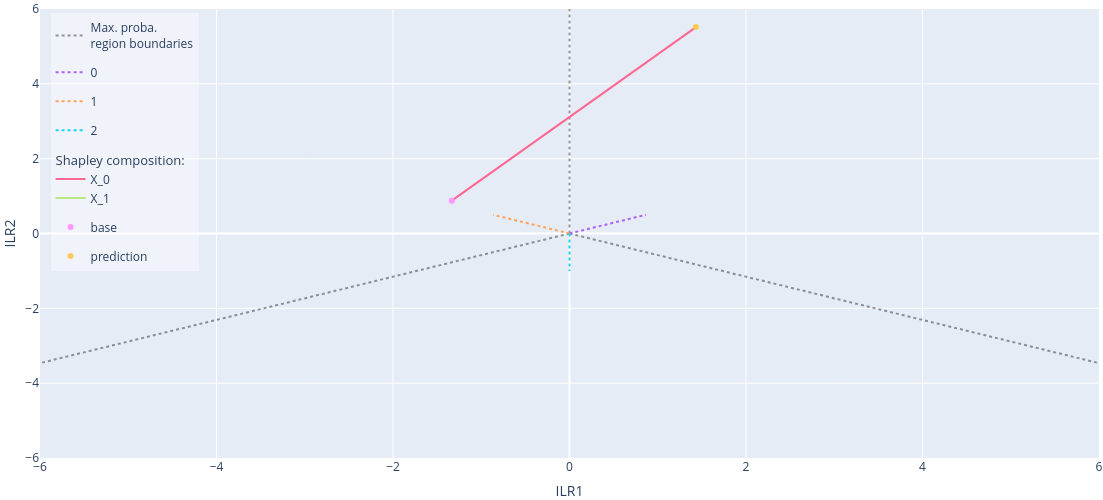

Sample of interest B = {'X': array([1, 0]), 'Y': 1}


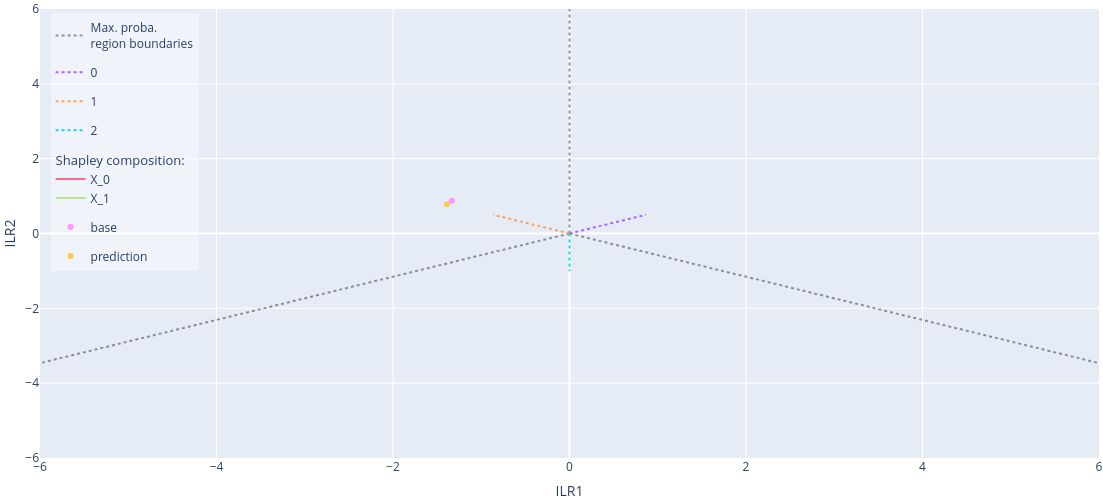

Sample of interest C = {'X': array([2, 0]), 'Y': 2}


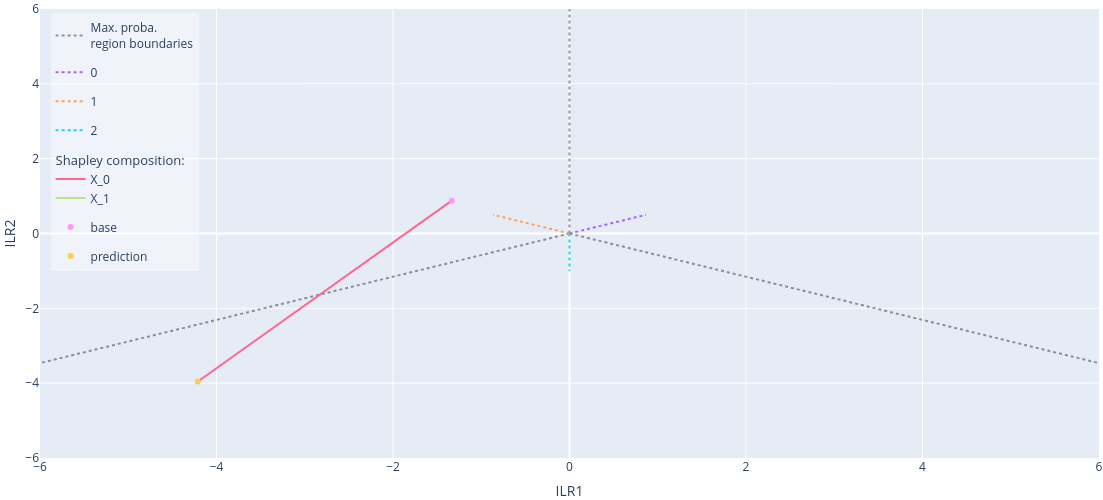

Sample of interest D = {'X': array([1, 1]), 'Y': 0}


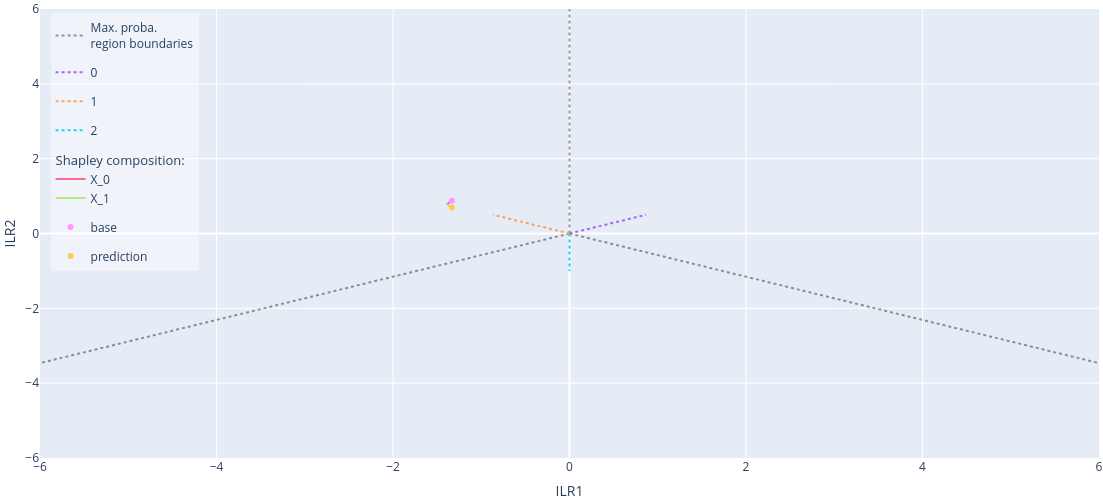

In [84]:
#PLOT the 3D ILR SPACE (CORRESPONDING TO THE CHOSEN ILR COMPONENTS LISTED IN BALANCES).
#plot range [-lim, lim]

#If shapley_sum is True, the sum of the shapley vectors are summed from the base distribution to the prediction

for sample_id, sample in samples_of_interest.items():
    print(f'Sample of interest {sample_id} = {sample}')
    (shapley, base) = explainer.explain_instance(sample['X'])
    ## Removed the composition without base and prediction
    #fig = explainer.plot_ilr_space(balances=[i for i in range(1, n_classes)], lim=6, figsize=500)
    #fig.update_layout(title=dict(text=f"Sample {sample_id} = {sample}"))
    #fig.write_image(os.path.join(out_dir, f"ex_eq4_{sample_id}_ilrplot.pdf"))
    
    fig = explainer.plot_ilr_space(balances=[i for i in range(1, n_classes)], shapley_sum=True, lim=6, figsize=500)
    fig.update_layout(title=dict(text=f"Sample {sample_id} = {sample}", automargin=True, yref='paper'))
    fig.write_image(os.path.join(out_dir, f"ex_eq4_{sample_id}_ilrplotsum.pdf"))

Sample of interest A = {'X': array([0, 0]), 'Y': 0}


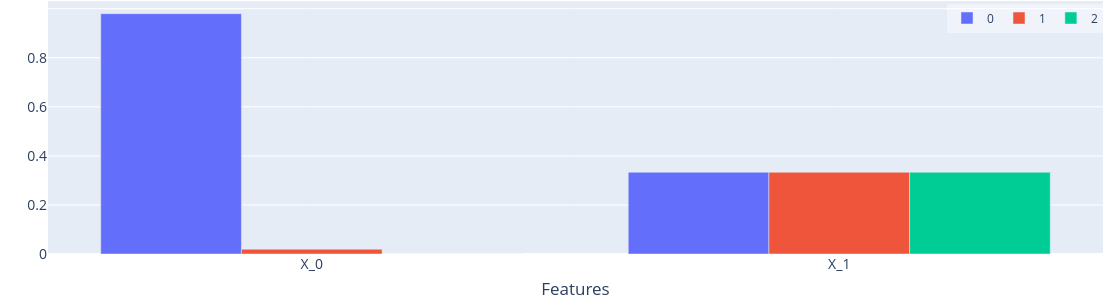

Sample of interest B = {'X': array([1, 0]), 'Y': 1}


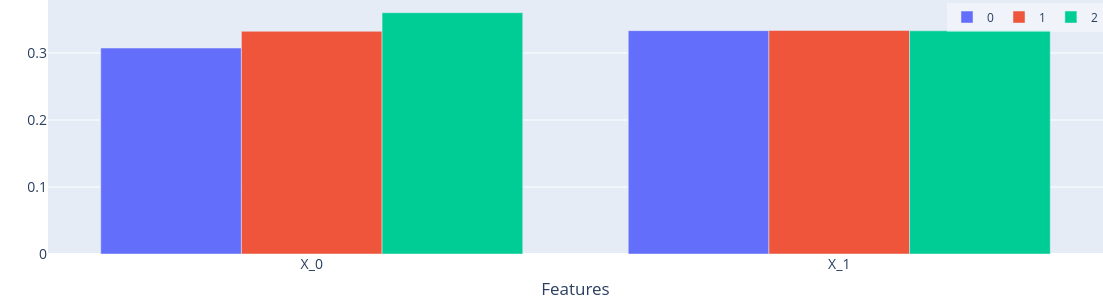

Sample of interest C = {'X': array([2, 0]), 'Y': 2}


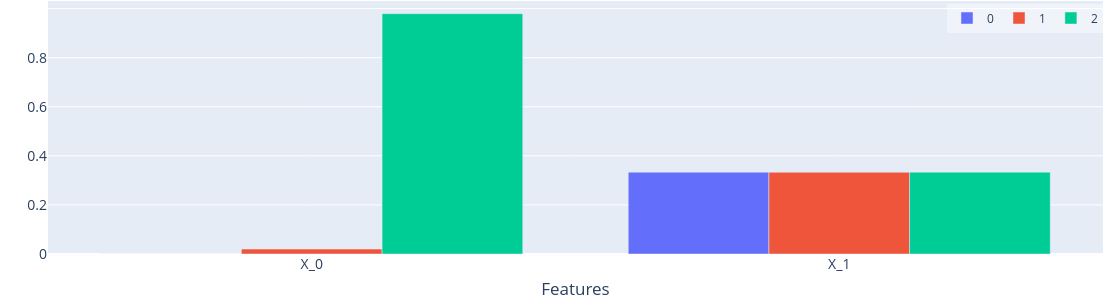

Sample of interest D = {'X': array([1, 1]), 'Y': 0}


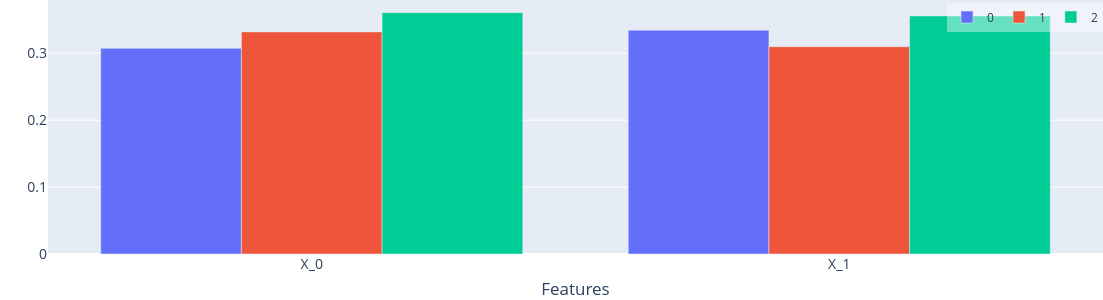

In [86]:
#Plot the Shapley compositions as histograms

for sample_id, sample in samples_of_interest.items():
    print(f'Sample of interest {sample_id} = {sample}')
    (shapley, base) = explainer.explain_instance(sample['X'])
    fig = explainer.shapley_histogram(figheight=300)
    fig.update_layout(title=dict(text=f"Sample {sample_id} = {sample}", automargin=True, yref='paper'))
    fig.write_image(os.path.join(out_dir, f"ex_eq4_{sample_id}_histo.pdf"))

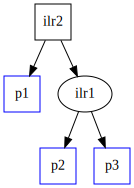

In [42]:
from sklearn.cluster import AgglomerativeClustering
from composition_stats import ilr, sbp_basis
from bifurc_tree import create_tree_from_sbp, init_graph, build_graph, sbp_from_aggloclustchildren
import plotly.graph_objects as go
from mahalanobis_matrix import mahalanobis_matrix
import matplotlib.pyplot as plt

M = mahalanobis_matrix(clf.predict_proba, X_test, Y_test)
sbpmatrix = sbp_from_aggloclustchildren(AgglomerativeClustering(metric='precomputed', linkage='average').fit(M).children_)

#basis = np.flip(sbp_basis(sbpmatrix), axis=0)
basis = sbp_basis(sbpmatrix)
root = create_tree_from_sbp(sbpmatrix, n_classes)

##Visualise the tree using graphviz
graph = init_graph()
build_graph(root, graph)
#graph.render('tree.pdf', view=True)
graph       #plot the bifurcation tree

# Comparison with SHAP

The SHAP library requires that the samples to be tested are inside the explained set.

In [116]:
#X_augmented_test = np.vstack((X_test, np.array([sample['X'] for sample in samples_of_interest.values()])))

In [117]:
#shap_values[0][-len(samples_of_interest):]

In [118]:
X_interest = np.array([sample['X'] for sample in samples_of_interest.values()])

In [114]:
import shap
shap.initjs()

explainer = shap.SamplingExplainer(clf.predict_proba, X_train,
                            output_names=[i for i in range(n_classes)])

shap_values = explainer.shap_values(X_interest)

  0%|          | 0/4 [00:00<?, ?it/s]

Sample of interest A = {'X': array([0, 0]), 'Y': 0}


<Figure size 640x480 with 0 Axes>

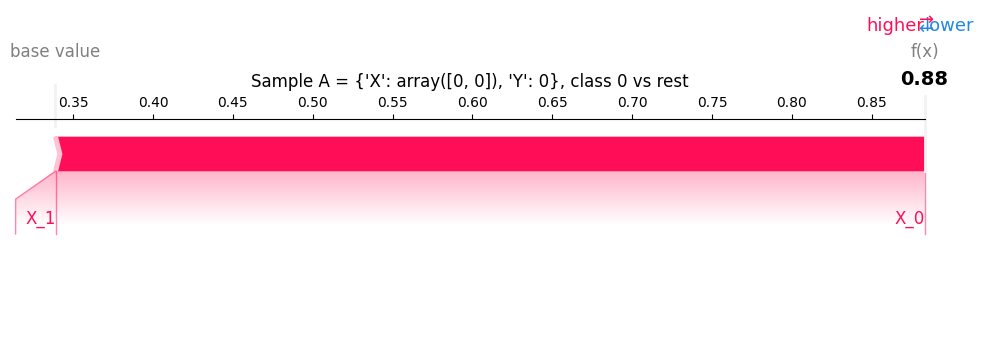

<Figure size 640x480 with 0 Axes>

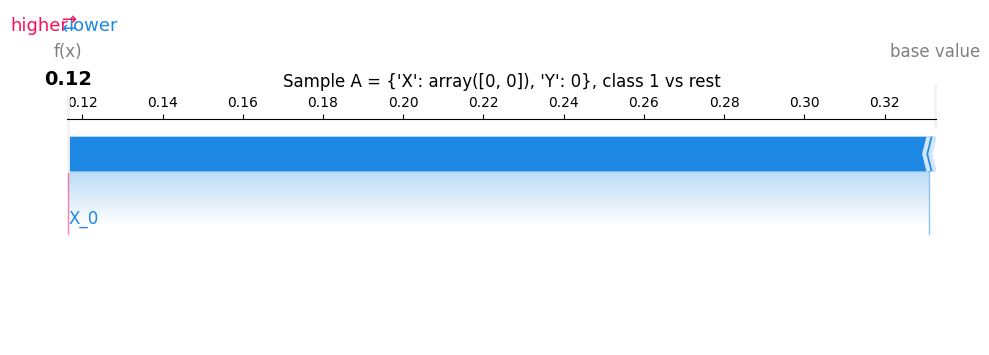

divide by zero encountered in scalar divide


<Figure size 640x480 with 0 Axes>

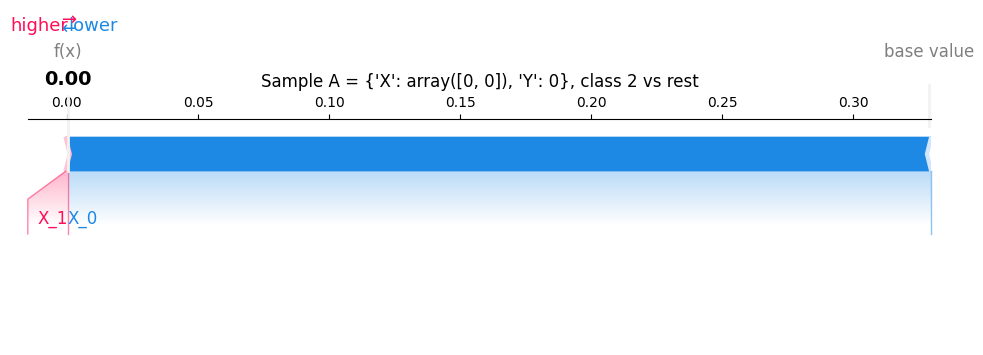

Sample of interest B = {'X': array([1, 0]), 'Y': 1}


<Figure size 640x480 with 0 Axes>

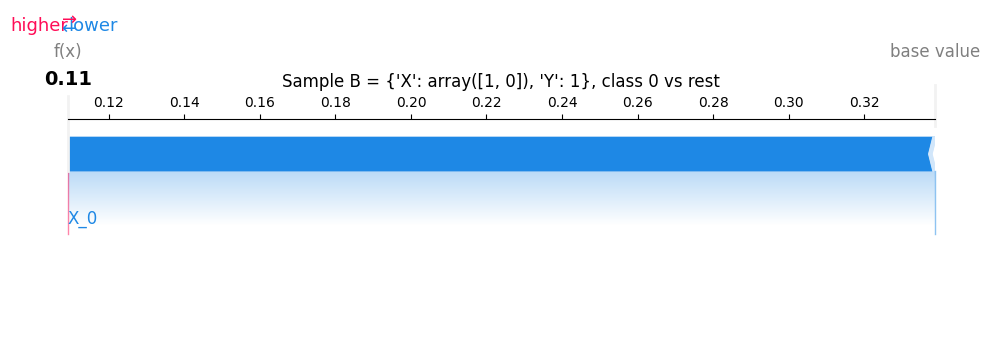

<Figure size 640x480 with 0 Axes>

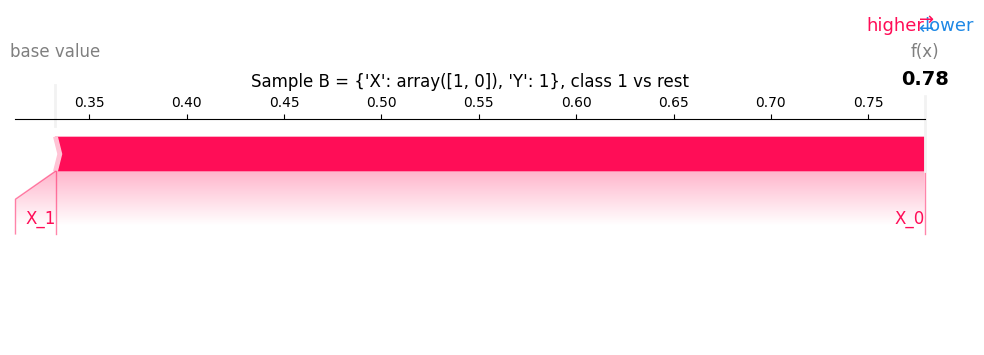

<Figure size 640x480 with 0 Axes>

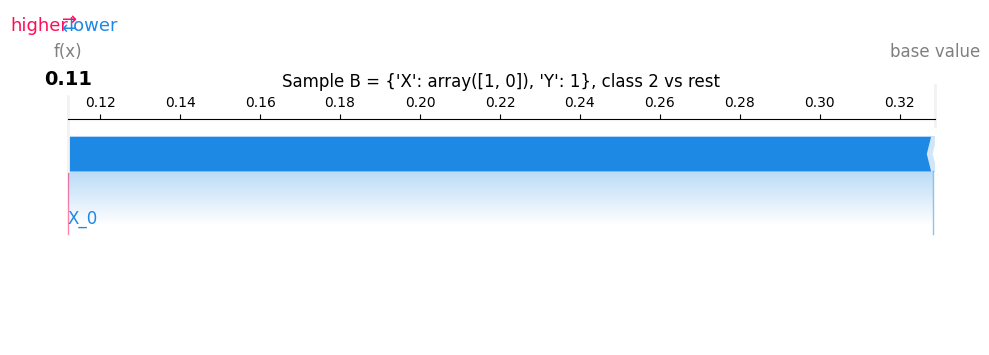

Sample of interest C = {'X': array([2, 0]), 'Y': 2}


divide by zero encountered in scalar divide


<Figure size 640x480 with 0 Axes>

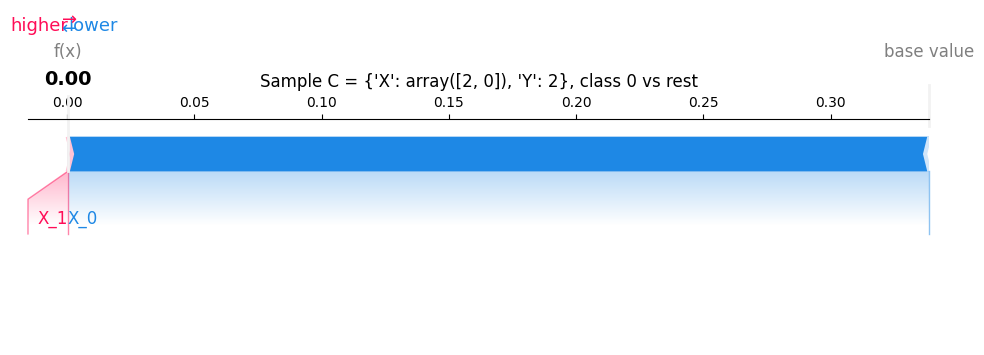

divide by zero encountered in scalar divide


<Figure size 640x480 with 0 Axes>

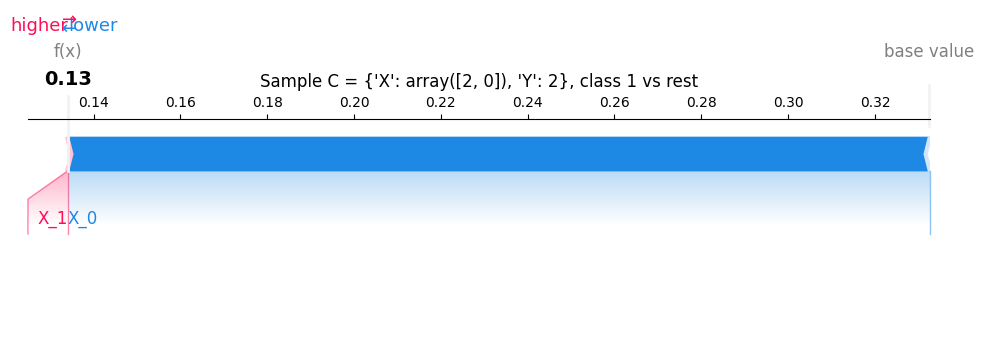

<Figure size 640x480 with 0 Axes>

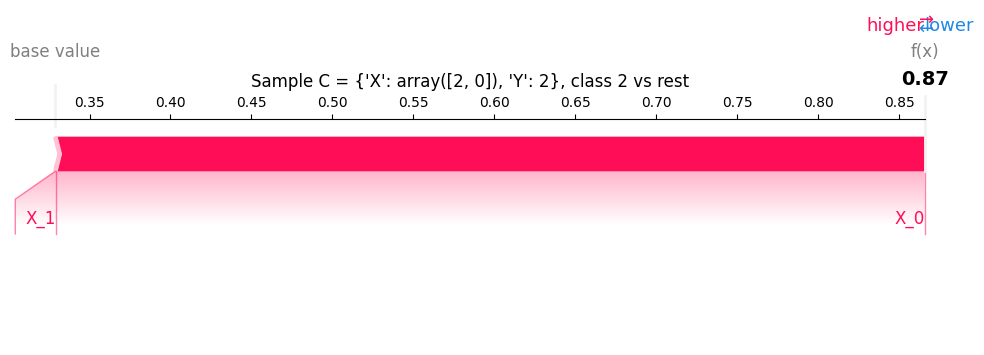

Sample of interest D = {'X': array([1, 1]), 'Y': 0}


divide by zero encountered in scalar divide


<Figure size 640x480 with 0 Axes>

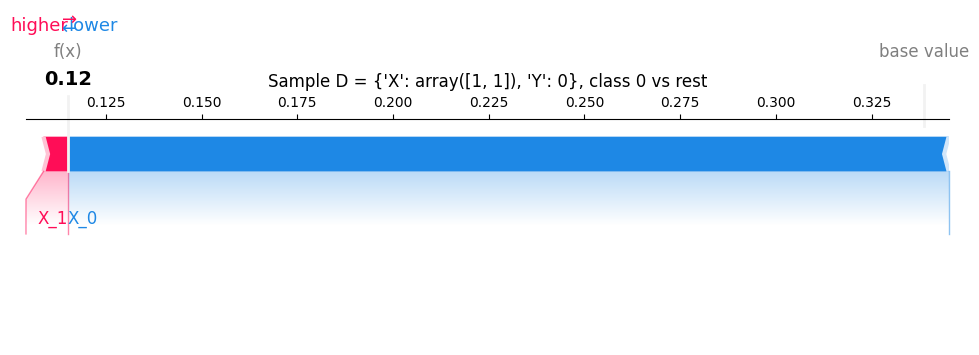

divide by zero encountered in scalar divide


<Figure size 640x480 with 0 Axes>

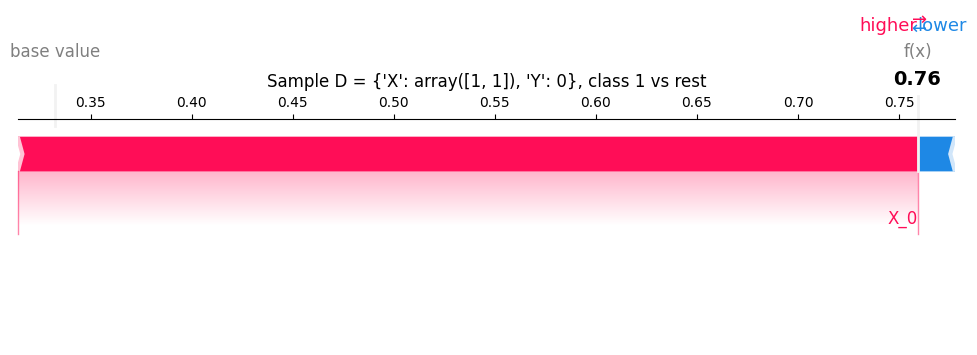

divide by zero encountered in scalar divide


<Figure size 640x480 with 0 Axes>

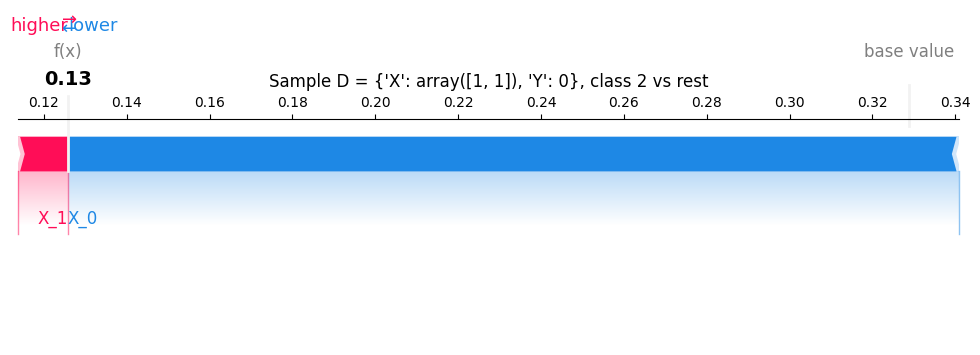

In [126]:

for i, (sample_id, sample) in enumerate(samples_of_interest.items()):
    print(f'Sample of interest {sample_id} = {sample}')
    for label_id in range(n_classes):
        plt.clf()
        shap.force_plot(
            base_value=explainer.expected_value[label_id],
            shap_values=shap_values[label_id][i],
            features=['X_0', 'X_1'],
            matplotlib=True, show=False,
            figsize=(10, 4)
        )
        plt.title(f"Sample {sample_id} = {sample}, class {label_id} vs rest")
        plt.tight_layout()
        plt.savefig(os.path.join(out_dir, f"ex_eq3_{sample_id}_shap_{label_id}.pdf"), dpi=300, bbox_inches='tight')
        plt.show()

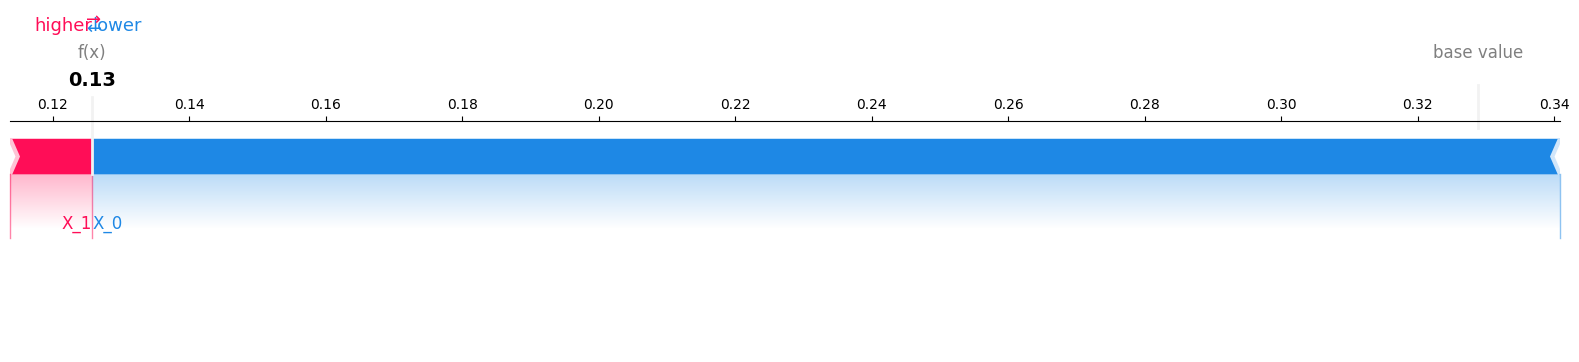

In [124]:
shap.force_plot(
            base_value=explainer.expected_value[label_id],
            shap_values=shap_values[label_id][i],
            features=['X_0', 'X_1'],
            matplotlib=True, show=False,
        )